## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

This is not too difficult as most of the code was given in the lesson. I just printed the images to the console instead of the window and waiting thing. 

In [2]:
#==============================================================
#
# import the nessesary libraries 
#
#===============================================================
import numpy as np
import cv2
import glob
import matplotlib; matplotlib.use('Qt4Agg')
from matplotlib import pyplot as plt
#%matplotlib qt



import pickle
import matplotlib.image as mpimg


### Define Image Points and Get Calibration Images

I defined the image points and used the provided images of a chesboard. This step was relatively straight forward as most of the code and data were provided. I plotted out all the calibration images. 

In [3]:
#===============================================================
#
# Define image points and load the calibration images 
#
# from class material with edits
#
#===============================================================
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)

objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

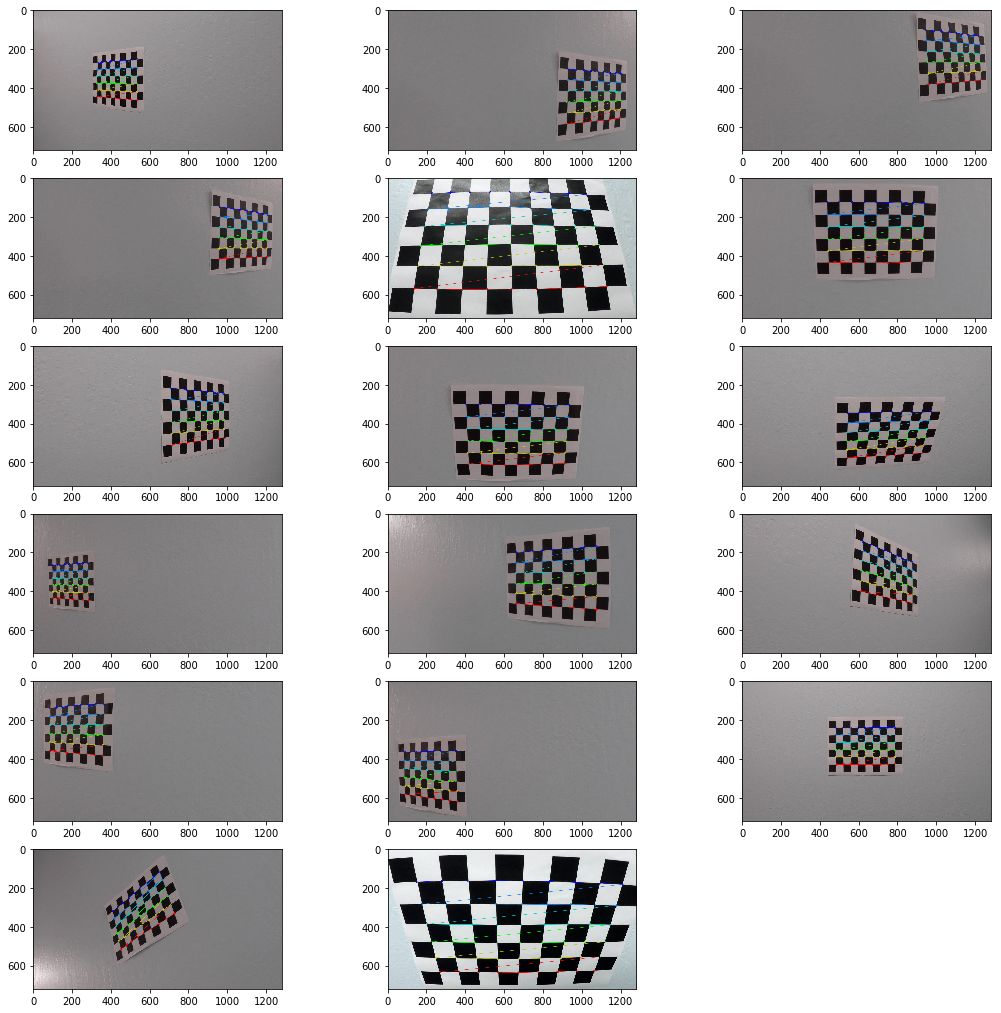

In [4]:
#+==============================================================
#
# Find chesboard corners and plot the boards with corners highlighted 
#
# from class material with edits
# 
#===============================================================

# set plot to console
%matplotlib inline

# Step through the list and search for chessboard corners
img_store = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        img_store.append(img)
#cv2.destroyAllWindows()


# save a couple for the writeup 
plt.imsave('output_images/chesboard_1.png',  img_store[0])
plt.imsave('output_images/chesboard_2.png',  img_store[4])

# now plot all the images 
# plot seected examples from original and rotated sets
plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(img_store):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)

### Run Calibration

CV2 provides a calibratecamera function, which I used along with the calculated objpoint, imgpoint, and the shape of the images. 

In [5]:
#==========================================================
#
# Camera calibration
#
# from class material with edits
#
#==========================================================

# calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Undistort Images 

The first step after calibration, is to use the calibration to undistort the images. This is important to get accurate measruemetns later on, even though in this particular application, it can be difficult to see the difference. The original image is on the left, and the undistorted on the right, you can see the slight difference when focusing on the road sign. Effectively this "flattens out" or "smooths out" the image so distances are more constant along the x and y axis. 

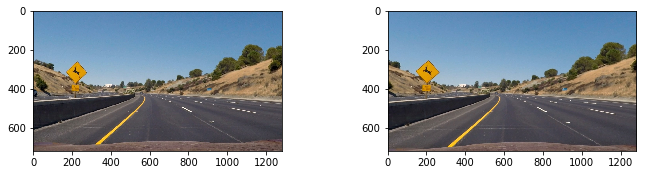

In [7]:
#==========================================================
#
# Undistort Image
#
# from class material with edits
#
#==========================================================

#img = cv2.imread('test_image2.png')

%matplotlib inline

# grab an example 
image = plt.imread('test_images/test2.jpg')

# one-liner using the class code and calib params, I left then unsettable 
def undistort(image):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted

undistorted = undistort(image)

# set a bigger plot size than default
matplotlib.rcParams['figure.figsize'] = (10,10)

# plot out both figures
img_store = []
img_store.append(image)
img_store.append(undistorted)

# save a couple for the writeup 
plt.imsave('output_images/reg.png',  image)
plt.imsave('output_images/undist.png',  undistorted)

plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(img_store):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)

## Thresholding Images 

Here I use HSL color space transofmations and the sobel operator to create binary (pixels on or off) images from the undistorted images. This is a very important set which greatly determines the effectiveness of the pipeline. It is analogous to a convolutional neural net learning features to identify the lane. This is of course, "by hand" selecting the features, which requires some though and trial and error. Additionally, there are tunable parameters here that can be changed to create different outcomes. I spend a lot of time here goofing around to find good thredholds. 

In [8]:
#==========================================================
#
# Color space and sobel operator for comvined threshold 
#
# from class material with edits
#
#==========================================================


#import numpy as np
##import cv2
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

# pass the image over to new variable (during testing)
img = undistorted

# reads in undistorted image and outputs binary image as a combo of different thresholded images
def apply_thresholds(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))*255
    
    # from the class notes
    combined_binary = np.zeros_like(sxbinary)
    
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # make the picture color binary rather than all one channel for each threshold
    #color_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_RGB2BGR).astype(np.float)
    
    return combined_binary

# test.    
result = apply_thresholds(img)


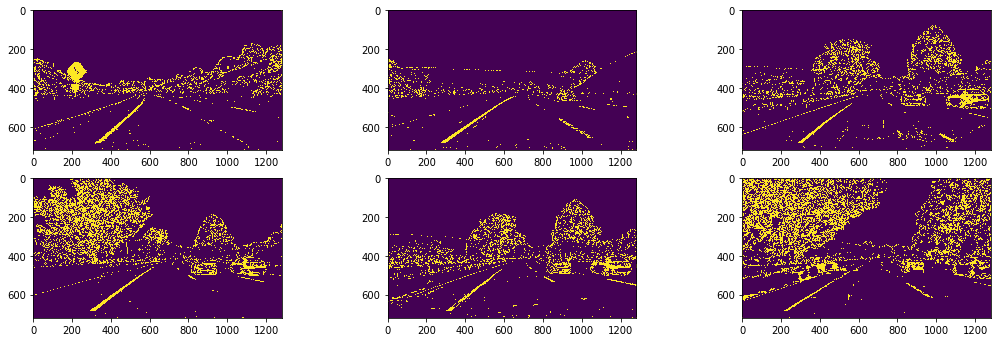

In [9]:
#==========================================================
#
# Plot the thresholded images
#
#==========================================================

images = glob.glob('test_images/test*.jpg')

img_list = []
for fname in images:
    img = cv2.imread(fname)
    img = apply_thresholds(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_list.append(img)

    

# save a couple for the writeup 
plt.imsave('output_images/binary1.png',  img_list[0])
plt.imsave('output_images/binary2.png',  img_list[4])

%matplotlib inline

plt.figure(figsize=(18, 18))
for i, img_loop in enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)
    

## Warping Images

Next I used the matricies from the calibation to create warped images that make a birds eye view of the road. This setp also has parameters which needed to be tuned, again, simply by trial and error. Additionaly, this set required designating the area which was warped, I did this by trial and error and also using gimp to get pixel locations. In my oppinion, this step can cause a lot of error if care is not take, I did this rather quickly. If this pipeine was to be implemented, I would defninately review the warp procudure. 

In [10]:
#==========================================================
#
# Make a warped version of the binary image  
#
# from class material with edits
#
# Should output a 'birds-eye-view' of the road
#
#==========================================================
def warp(img, mtx, dist):
    
    img_size = (img.shape[1], img.shape[0])
    
    # !!! Source points!! hand picked, trail and error and looking at x y values in gimp
    # 580 WAS 600
    offset = 150
    src = np.float32([[600, 450], [780, 450], [1150, 670], [250, 670]])
    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
    # Given src and dst points, cculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # get the inverse
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix (for unwarp)
    return warped, M, Minv

#===============================================================================
# test run
img = result
test, M, Minv = warp(img, mtx, dist)

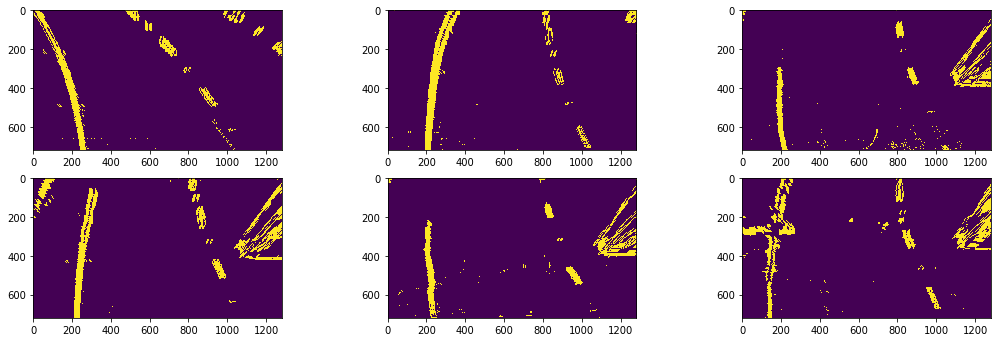

In [11]:
#==========================================================
#
# Plot the test images warped. 
#
#==========================================================

images = glob.glob('test_images/test*.jpg')

img_list = []
for fname in images:
    img = cv2.imread(fname)
    img = apply_thresholds(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, M, Minv = warp(img, mtx, dist)
    img_list.append(img)
    
    
# save a couple for the writeup 
plt.imsave('output_images/warp1.png',  img_list[0])
plt.imsave('output_images/warp2.png',  img_list[4])

%matplotlib inline

plt.figure(figsize=(18, 18))
for i, img_loop in enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)


## Fitting the Original Polynomials 

This step is almost entirely from the class notes. Also, this is not a function. Its worth noting that because this particular piece of code will not be in the final pipeline. I use this code to get a first fit from an example image. I then use that first fit to initilize the last_fits slot in the lane class I define later. Major things happening here are a histogram search of the bottom half of the image, and then an iterative window search that identifies pixels that will be considered part of the lane. The next piece of code was also provided by udacity and shows how this process performed on one of the example images. 

In [12]:
#==========================================================
#
# Fit the polynomials to the warped image lane lines 
#
# from class material with edits
#
#==========================================================

# pre function test: 
binary_warped = test


# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
#out_img = binary_warped

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 150
# Set minimum number of pixels found to recenter window
minpix = 10
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

#==================================================
# These are saved and put into the final pipe line function
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

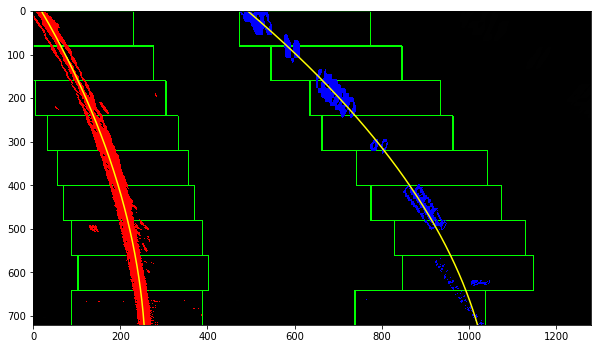

In [13]:
#==========================================================
#
# Plot the resulting fit for example 1
#
# from class material with edits
#
#==========================================================

# set plot size 
matplotlib.rcParams['figure.figsize'] = (10,10)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('output_images/highlighted_lines.png')

## The Polynomial Fit Function for the Pipeline

Next, I used more code provided in the class to create a polynomial fit function that will go into the pipeline.
This function uses the previous polynomial fits to make the next polynomial fits. It is initialized once with the code from the section above and then loop through using the last fit for the next fit. That way, the window search only needs to be used once. There is one wrinkle to this, in that I ended up using the previous 200 fits with a weighted average, but, the poly function deals only with 2 fits at a time. The next piece of code shows how the function performs on an example image. 

In [14]:
#==========================================================
#
# from the class notes 
#
# with edits 
# 
# The polyfit function which will be reapeated in the pipline
#===========================================================

# This function will be looped in the pipeline, accepting the 
#   new warped image and the origian right_fit and left_fit 
def ploy_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, lefty, righty, leftx, rightx, left_fit, right_fit

left_fitx, right_fitx, lefty, righty, leftx, rightx, left_fit, right_fit = ploy_fit(binary_warped, left_fit, right_fit)

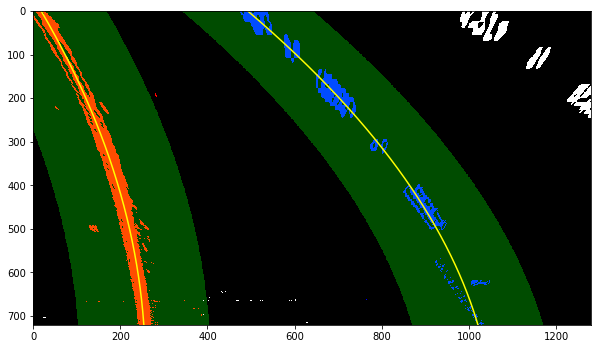

In [15]:
#==========================================================
#
# from the class notes 
#
# with edits 
# 
# This final visualization for the polyfit post search 
#===========================================================

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('output_images/loop_fit.png')

## Calculating Radius of Curvature and Distance from the Center 

The class notes provided some code and suggestions for calculating radius and center distance. These will later be plotted on to the final images. The function given in the class notes was used to calcualte radius of curvature for each lane line. I then rounded each to the nearest whole number and took the minimum of them to print out. the reason I did this was incase I ended up needing a "sanity check" on the radius then I wanted to use the potentially worst one for the given fit. I calculated center distance by taking the average pixel x position in the bottom 25% of the picture and finding the pixel distance to each side from the center of image, and then converting pixel distances to meters with a constant. There are a lot of assumptions wrapped up in there, but the reasult did not seem too bad. 

In [17]:
#===================================================
#
# Calculate radius and distance from center 
#
# from class material with edits
# also inspired by: [https://github.com/sumitbinnani/CarND-Advanced-Lane-Lines/blob/master/Pipeline%20for%20Advance%20Lane%20Detection.ipynb]
#===================================================

##ym_per_pix = 3/72.0 # meters per pixel in y dimension
#xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
#y_eval = 700
#midx = 650
def calc_radius(left_fit, right_fit, lefty, righty, leftx, rightx):
    # from class notes, replace ploty with fity
    y_eval = 720
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    # Fit new polynomials to x,y in world space
    # !! replace ploty with lefty and righty
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters and I' going to take the minimum
    
    #curvature =(left_curverad, 'm', right_curverad, 'm')
    curvature_text = [np.round(left_curverad, 0), np.round(right_curverad, 0)]
    
    # now calcuate postition from right and left lane lines
    # but only from the bottom 25% of the fit
    left_ave = np.mean(leftx[int(len(leftx) - len(leftx)*0.25) : len(leftx)])
    right_ave = np.mean(rightx[int(len(rightx) - len(rightx)*0.25) : len(rightx)])
    
    
    m_from_left = np.round((640 - left_ave)*xm_per_pix, 2)
    m_from_right = np.round((right_ave - 640)*xm_per_pix, 2)
    
    left_of_cent = (m_from_left + m_from_right)/2 - m_from_left
    right_of_cent = (m_from_left + m_from_right)/2 - m_from_right
    
    center_text = [left_of_cent, right_of_cent]
    

    #print("Radius of Curvature: %f" % curvature)
    return curvature_text, center_text

#===========================================================================================
# test 
calc_radius(left_fitx, right_fitx, lefty, righty, leftx, rightx)



([461.0, 270.0], [-0.2799999999999998, 0.28000000000000003])

## Lane Class Definition

I did not use the structure suggested in the class notes, as my code as written to this point could not take advantage of all the slots. So, I paired it down to what I hoped would be enough to smoothing predict lane lines. Here, I store a nd array abject of n number of past polynomial fits. I used this later to calcuate a weighted average, with recent fits being more important than previous fits through a learning function calculating the weights. The n number flexibiity is important as I needed to tune this number to get good results. 

In [18]:
#=======================================================================================
# Define the line class for video processing 
#
#  From class notes, but way simplified
#=====================================================================================

# Define a class to receive the characteristics of each line detection
class lane():
    def __init__(self):
        self.last_fits = None


## Draw lane lines

Finally I'm drawing lane lines! This is the first time the fits will be projected back onto the road visually. I used the suggested code from the lesson to build the fucntion. Additionally, this fucntion takes the output of the  polynomial fits to write text in the top right corner displaying the calculations. I ran the funtion on a test image below. 

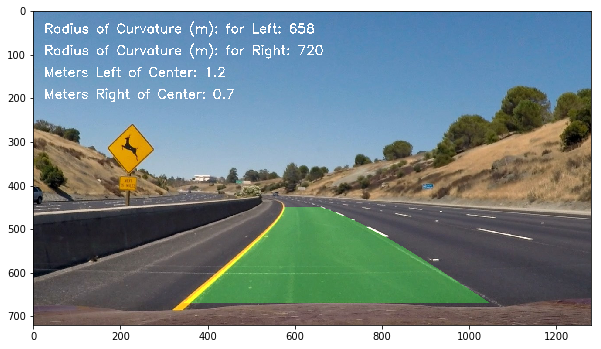

In [26]:
#==========================================================
#
# from the class notes with edits 
# aslo inspired by [https://github.com/mvirgo/Advanced-Lane-Lines/blob/master/full_pipeline.py]
# 
# plots the lane line back onto the image
#=======================================================

def draw_lane(test, image, left_fitx, right_fitx, curve_text, center_text):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(test).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Get the new poly fits  
    #left_fitx, right_fitx = ploy_fit(binary_warped, left_fit, right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    #result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
    #font = cv2.FOT_HERSHEY_TRIPLEX
    curve_text1 = 'Radius of Curvature (m): for Left: ' + str(curve_text[0])
    curve_text2 = 'Radius of Curvature (m): for Right: ' + str(curve_text[1]) 
    
    # now lane distance. Add this commented out line to print out dist from right line also
    #+ ' & right line: ' + str(center_text[1])
    center_text1 = 'Meters Left of Center: ' + str(center_text[0]) 
    center_text2 = 'Meters Right of Center: ' + str(center_text[1])
    image_text1 = cv2.putText(result, curve_text1, (25,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    image_text2 = cv2.putText(image_text1, curve_text2, (25,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    image_text3 = cv2.putText(image_text2, center_text1, (25,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    image_text4 = cv2.putText(image_text3, center_text2, (25,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    #result = cv2.addWeighted(image_text2, 1, newwarp, 0.3, 0)
    
    return image_text2

# test the draw function
# just to test, put in hard values
result = []
result = draw_lane(test, image, left_fitx, right_fitx, [658, 720], [1.2, 0.7])
plt.imshow(result)

plt.savefig('output_images/draw_test.png')

## Saving polynomial fits and applying a weighted average 

When I ran this pipeline "raw" or just displaying each fit as the came, the resutling video was not encuraging. In an effort to solve this problem I built a class object to save n number of previous fits, and caculate the weighted average of the fits (latest predictions beining most important). This greatly improved the result, but added more parameters which need to be tuned and likely have different optima depending on the state of the video (dark, light, raining, shadows, etc). The average fit function calculates the averge of the polynomial wieghts, and the lane step function keeps track of the last n polynomial weights. 

In [27]:
#==========================================================
#
# Create functions to save n poly fits and average them to get the next 
#
# effectively, this gives the lane a little bit of "delay" which may make the lane predictions smoother 
#
#=======================================================


# define a function to store and average previous fits in attempt to smooth out the line
def average_fit(prev, n):
    ave_fit = np.zeros([3])
    for i in range(0, 3):
        ave_fit[i] = np.average(prev[0:n, i:i+1].transpose(), axis = 1, weights = np.linspace(.1, n*.1, n, endpoint=False))
    return ave_fit

# this iterates throught he polyfits, replacing the oldest one with the newest one, and "walking down" all
#   the others
def lane_step(prev, current, n):
    for i in range(0, n-1):
        prev[i:i+1, :] = prev[i+1:i+2, :]
    prev[n-1:n, :] = current
    return prev

# initilize the test fit object
te = np.zeros([9, 3])
te[0:] = left_fit
te[1:] = right_fit
te[2:] = left_fit
te[3:] = right_fit
te[4:] = left_fit
te[5:] = right_fit
te[6:] = left_fit
te[7:] = right_fit
te[8:] = left_fit

#============================================================================
# testing the average function
average_fit(te, 9)

array([ -4.68666041e-04,   8.45185808e-01,   2.29068835e+02])

In [28]:
#===============================================================
# Testing lane step. This should iterate putting more and more 
#  recent left_fits in, while deleting the top ones one by one

lane_step(te, left_fit, 9)

array([[ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01]])

## Putting together the whole pipeline

Yes! Finally the whole pipeline can be put together. The pipeline utilizes the undistort, apply_threholds, warp, average_fit, poly_fit, calc_radius, draw_lane, and lane_step functions. Addidtionally, it adds a parameter dictating how many polynomial weights to save and average over. This is "hard-coded" as a few other things are, but it works fine for a research document like this. The whole pipline would have to be more robust to be acutally implemented. 

In [29]:
#=======================================================================================
#
# build the whole pipeline for processing images with the above functions 
#
# There are a few parameters and object "hard coded" here, but the pipeline works 
#  this however, would be a problem if I was implement this solution beyond 
#  a research document. 
#=====================================================================================

def image_pipeline(input_image):
    # get teh undistorted warped base image 
    undistorted = undistort(input_image)
    thresholded = apply_thresholds(undistorted, s_thresh=(90, 240), sx_thresh=(60, 160))
    warped, M, Minv = warp(thresholded, mtx, dist)
    
    # calcualte the average fits for the last 4 fits
    ave_right_fit = average_fit(right_lane.last_fits, 200)
    ave_left_fit = average_fit(left_lane.last_fits, 200)
    
    # continue down the pipe from poly fit function
    left_fitx, right_fitx, lefty, righty, leftx, rightx, left_fit, right_fit = ploy_fit(warped, ave_left_fit, ave_right_fit)
    curve_feed, center_feed = calc_radius(left_fitx, right_fitx, lefty, righty, leftx, rightx)
    result = draw_lane(warped, input_image, left_fitx, right_fitx, curve_text = curve_feed, center_text = center_feed)
    
    # keep the fits rolling through the lane classes  
    right_lane.last_fits = lane_step(right_lane.last_fits, right_fit, 200)
    left_lane.last_fits = lane_step(left_lane.last_fits, left_fit, 200)
    
    # get the final image
    return result

## Initilize and Test Pipeline

The pipeline requires an initilized objecgt for right_lane and left_lane last_fits slots. I made this object with repeated fits for the first test image for the same n as is set in the pipeline. After making the object I ran the pipeline on a test image. 

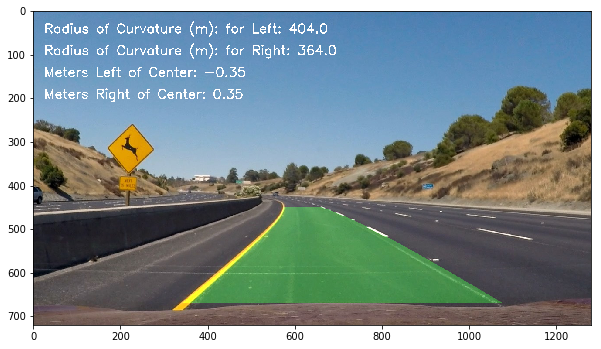

In [32]:
#=======================================================================================
#
# Initilize line classes and test pipeline on test image 
#
# 
#=====================================================================================

# Create the object 
right_lane = lane()
left_lane = lane()

# initilize with test 1

# initilize the fit objects
n = 200
l_start = np.zeros([n, 3])
for i in range(0, n): 
    l_start[i:] = left_fit

r_start = np.zeros([n, 3])
for i in range(0, n): 
    r_start[i:] = right_fit

right_lane.last_fits = r_start
left_lane.last_fits = l_start
    
i_im = plt.imread('test_images/test2.jpg')
 
ts = image_pipeline(i_im)

plt.imshow(ts)

# save the output to put in the writeup
plt.savefig('output_images/final_test.png')

## Process the Video 

Now that the pipline works and the lane class keeps track of the polynomial weights for averaging, I can pipe video frames though it. I used the moviepy package for this. At this step, I can really begin to see the value of creating the lane class, as the video operations are greatly streamlined by taking care of saving information dynamically behind the scenes. 

In [31]:
#=======================================================================================
#
#  Processing the videos 
#
# Citations: [https://github.com/mvirgo/Advanced-Lane-Lines/blob/master/full_pipeline.py]
# and [https://pypi.python.org/pypi/moviepy]
# and [https://stackoverflow.com/questions/40965423/how-to-use-fl-image-function-in-moviepy-within-python]
#=====================================================================================

# Import moviepy to stream movie through the pipeline function. 
from moviepy.editor import VideoFileClip

# loop the pipeline function over the video one frame at a time. 
original_video = VideoFileClip("project_video.mp4")
lane_video = original_video.fl_image(image_pipeline)

# writes out the video to 
lane_video.write_videofile('lane_lines_200.mp4', audio=False)

[MoviePy] >>>> Building video lane_lines_200.mp4
[MoviePy] Writing video lane_lines_200.mp4


100%|█████████▉| 1260/1261 [02:44<00:00,  8.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_lines_200.mp4 



## Discussion and Conclusion

Wow, that was quite a project, one which could really be upgraded a lot and have much better performance. It was interesting to get a taste of what "doing it by hand" takes rather than using deep learning. Although this project sucessfully tracked the lane lines with reasonable accuracy, there is definately room for improvement. The biggest improvement from single fitting I made was saving a specified number of polynomial fits from each side and applying a wiehgted average to each of the three polynomial weights. The wieghted average took the most recent fits as more important than previous ones. Although this improved the pipeline, it is still not perfect and there are times when the polyfit can be seen wandering a bit. 

One interesting challange was everytime I implemented more code to solve a problem, the process introduced more tunable parameters. Although these processes and parameters made the output much better, they took deep knowledge of the process or just a bunch of trial and error to tune. Also, some of these parameters had interdependence, where the optimal values for some change when values are changed for others. Since this is a pretty hetogenous process, even a score or so parameters can start to be a hassle when codeing by had. 

I'm pretty convienced that my process is not operating at is optimal and more parameter tuning could really help. One way to do this in the future would be to use a metaheuristic optimization such as particle swarm or a genetic algorithm. These types of optimizations are valuable when the gradient of the problem is difficult or impossible to esitmate and the parameters are very heterogenous. It would be cool to see how much better the pipeline could get by tuning before making it more complex and thus slower. 